In [1]:
import pandas as pd
import matplotlib 
import numpy as np
import matplotlib.pyplot as plt
import math


import seaborn as sns
import os
import cv2

from skimage import io
from sklearn.utils import shuffle     

# Import libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, GlobalAveragePooling2D, Conv2D, Input, MaxPool2D, Flatten, AveragePooling2D, BatchNormalization 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.metrics import Recall

from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

import datetime


# Pneumonia diagnosis classification

## Proof of concept - medical stuff helping tool

#### Author: Tanyo Tanev

#### Abstract

As all sciences acquire new knowledge, in the last decades, medicine and healthcare are fields of many new improvemens and upgrades. The human life expectancy rises. Many desieses and conditions become cureable, or at least amendalbe to some degree. The demand for healthcare services increases all over the world, in surgery, preventive medicine, diagnosis, etc. The need for highly educated and experienced doctor creates scarcity, competition and increases the workload of any personel. On the other hand, the rapid improvement of ML and DL methods, computational power gives the opportunity to create various helping tools, which can reduce diagnosis duties of doctors.

### 1. Introduction

The study used neural networs with transfer learning with VGG19 on 5863 X-rays for Pneumonia diagnosis. It is a proof-of-concept study, which, if improved further could lead to reduced overhead of medicine stuff, increase healthcare services, provided in small town areas, and reduced waiting time for diagnosis in some countries. 


Neural networks are ideal in recognizing diseases using scans since there is no need to provide a specific algorithm on how to identify the disease. Neural networks learn by example so the details of how to recognize the disease are not needed. What is needed is a set of examples that are representative of all the variations of the disease. The quantity of examples is not as important as the ‘quantity’. The examples need to be selected very carefully if the system is to perform reliably and efficiently.

The disease scanning, for example pneumonia, consists of very similar image types, which standardises the process. The colours, the pose, the image dimensions should be very similar. This should increase the available training images and potentially lead to 100% accuracy and recall. In practice, there are some patient conditions that are on the edge, so to say. A patient could has pneumonia, but it could not be possible to notice it from the scan. 

Regretfully, I lost the work from Keras on which mostly based this study. It was not intentional.

### 2. Previous work

This is considerably famous data set, with various experiments on it. Some of the concentrate on accuracy, other seek high recall, with various results - from 0.87 to 0.92 accuracy and various results on recall - from 0.86 to 0.96. This is obviously not full review of the results, as they are too many, and new are added by the day. One even states 0.99% accuracy, but it is with more than 134 million trainable parameters (actually VGG16 structure) [1], trained on 5 epochs. The considered in this work model has a little more than 20 million non-trainable and 3 million trainable parameters.
There are works that reach even 100 % accuracy [2], although it is performed on other dataset with COVID-19 x-ray. The similarity of the pneumonia symptoms makes the used appoach similar to the ones with pneumonia. Actually, this was one of the goals of this work - to check whether a model, trained on X-ray from pneumonia patients will give same high results on images from COVID-19 patients.

The work in [3] shows orderly arranged model creation and hyper parameter tuning, trained on 100 epochs with early stopping callback.

### 3. Data sources

The data source is the Kaggle data set Chest X-Ray Images (Pneumonia) [4]. 
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert. Acknowledgements to: [5]

### 4. Reading the data and initial exploration

In case the study needs to be tried - the dataset must be downloaded from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/code?datasetId=17810&sortBy=voteCount, and the ROOT_PATH specified.

Global variables

In [2]:
IMAGE_WIDTH = 300 # смених го от 224 на 300
IMAGE_HEIGHT = 300
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
#BATCH_SIZE = 6
#EPOCHS = 15

# Root path
ROOT_PATH = "C:/Programs/TT/DL/PROJECT/data/archive/chest_xray/"





# 'train' path
TRAIN = ROOT_PATH + 'train/'

# 'test' path
TEST = ROOT_PATH + 'test/'

# 'validation' path
VAL = ROOT_PATH + 'VAL/'
VAL_NORMAL = ROOT_PATH + "val/NORMAL/"
VAL_SICK = ROOT_PATH + "val/PNEUMONIA/"

In [3]:
label_names = ['NORMAL', 'PNEUMONIA']
label_names_ = {label_names:i for i, label_names in enumerate(label_names)}
label_names_

{'NORMAL': 0, 'PNEUMONIA': 1}

In [4]:
# .DS_Store is added due to certain reading problems while working with MacOS

def load_data():
    
    datasets = [TRAIN,
                TEST]
    
    output = []
    
    for dataset in datasets:
        print("Loading:", dataset)
        
        images = []
        labels = []
        
        for folder in os.listdir(dataset):
            
            if folder != '.DS_Store':

                print("Folder:", folder)
                label = label_names_[folder]

                for file in os.listdir(dataset + '/' + folder):

                        try:

                            img_path = dataset + '/' + folder + '/' + file

                            image = cv2.imread(img_path)
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                            image = cv2.resize(image, IMAGE_SIZE)

                            images.append(image)
                            labels.append(label)


                        except Exception as e:
                            print(e, file)
                
            else:
                continue
                               
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output         

In [5]:
(X_train, y_train), (X_test, y_test) = load_data()

Loading: C:/Programs/TT/DL/PROJECT/data/archive/chest_xray/train/
Folder: NORMAL
Folder: PNEUMONIA
Loading: C:/Programs/TT/DL/PROJECT/data/archive/chest_xray/test/
Folder: NORMAL
Folder: PNEUMONIA


In [6]:
# Shuffle data
   
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [7]:
# Let's see how the data looks

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (5166, 300, 300, 3)
y_train: (5166,)
X_test: (552, 300, 300, 3)
y_test: (552,)


In [8]:
# How many labels of each kind are there in 'train'?

print(np.unique(y_train))
print(y_train.tolist().count(0))
print(y_train.tolist().count(1))

[0 1]
1316
3850


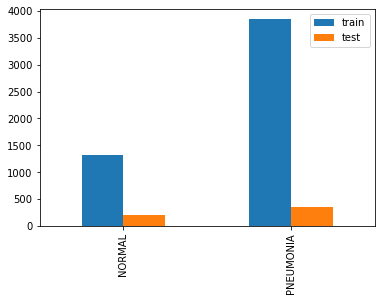

In [9]:
# Images for each kind, train/test

_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)

pd.DataFrame({'train': train_counts,
             'test': test_counts},
            index=label_names).plot.bar();

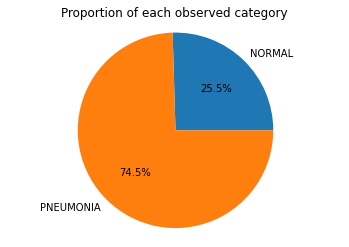

In [10]:
# What's the proportion?

plt.pie(train_counts,
        explode=(0, 0) , 
        labels=label_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [11]:
# Reading 'validation' images 

from skimage.io import imread
import cv2


def read_data(path, category):
    X = []
    Y = []
    
    for file in os.listdir(path):

        if file != '.DS_Store':

            try:

                image = cv2.imread(path + file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                X.append(image)

                Y.append(label_names_[category])

            except Exception as e:
                    print(e, file)
                    
        else:
            continue
    
    return np.array(X), np.array(Y)


X_val1, y_val1 = read_data(VAL_NORMAL, 'NORMAL')
X_val2, y_val2 = read_data(VAL_SICK, 'PNEUMONIA')

print(X_val1.shape)
print(y_val1.shape)
print(X_val2.shape)
print(y_val2.shape)

# Concatenating

X_val = [X_val1, X_val2]
X_val = np.concatenate(X_val)

y_val = [y_val1, y_val2]
y_val = np.concatenate(y_val)

print("Shape final 'X_val':", X_val.shape)
print("Shape final 'y_val':", y_val.shape)

(69, 300, 300, 3)
(69,)
(69, 300, 300, 3)
(69,)
Shape final 'X_val': (138, 300, 300, 3)
Shape final 'y_val': (138,)


In [12]:
# Normalization

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

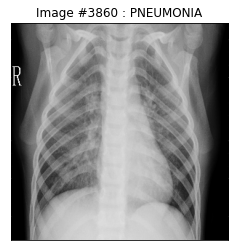

In [13]:
# Checking images

def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + label_names[labels[index]])
    plt.show()
    
display_random_image(label_names, X_train, y_train)

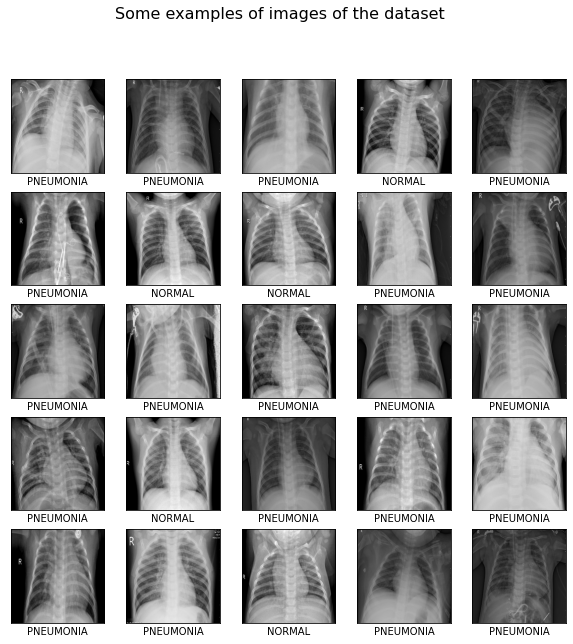

In [14]:
# Checking 25 images

def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[0+i], cmap=plt.cm.binary)# на мястото на нулите имаше 255
        plt.xlabel(label_names[labels[0+i]])# на мястото на нулите имаше 255
    plt.show()
    
display_examples(label_names, X_train, y_train)

The dataset is not small, but in order to increase the training set, for a more robust model, we will use the data augmentation class in Keras ImageDataGenerator. This way we will try to avoid overfitting the train set, achieve lower loss, higher recall/accuracy [6].

In [15]:
# Using 'ImageDataGenerator'

datagen = ImageDataGenerator(
        featurewise_center=False,  # establece la media del dataset a 0
        samplewise_center=False,  # media de cada entrada a 0
        featurewise_std_normalization=False,  # divide cada input por la std del dataset
        samplewise_std_normalization=False,  # divide cada entrada por su std
        zca_whitening=False,  # específico para imágenes y gestión de sus colores
        rotation_range = 30,  
        zoom_range = 0.2,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False) 

validation_datagen = ImageDataGenerator()

datagen.fit(X_train)

The chosen metrics for the study, expect for accuracy and loss (binary crossentropy ), as it is a medical proof of concept, and the disease is pneumonia, the paper focus is missing as less as possible true positives, pneumonia confirmed cases. Actually, in the begging the training process was only with accuracy, and later the recall was added. No custom metrics was needed to be prepared at the moment.

### 5.Model building and transfer learning

Below, the history data from models, trained on a small training and validation data. For a reference, it is not deleted.

In the beggining I used VGG16, but updated it to VGG19. At first, the model was with trainable layers, which increased the training time a lot. The input shape was 128,128,3.

The experiments with 128,128,3 showed not good enough results, due to the loss of information. In addition without VGG19, the achieved results with 0.84-0.86% accuracy, with all data, on the 50 epoch. Of cource, with increasing the model capacity, like in [9] the accuracy should improve as well. Of course, with more than 20 million trained parameters and transfer learning from award winning model should have a higher result.

In [16]:
expert_conv_transfer = VGG19(weights = 'imagenet', include_top = False, input_shape=(300,300,3))


IMAGE_SIZE_INPUT = (300, 300, 3)

for layer in expert_conv_transfer.layers:
      layer.trainable = False

tweaked_model_7 = Sequential()
tweaked_model_7.add(Input(IMAGE_SIZE_INPUT))
tweaked_model_7.add(expert_conv_transfer)
tweaked_model_7.add(Conv2D (124, kernel_size = (3,3), padding = "same", activation = "relu"))
tweaked_model_7.add(BatchNormalization()) 
tweaked_model_7.add(MaxPool2D())     # може би да уточня страйд и големина на филтър
tweaked_model_7.add(Conv2D (124, kernel_size = (3,3), padding = "same", activation = "relu"))
tweaked_model_7.add(BatchNormalization()) 
tweaked_model_7.add(MaxPool2D())
tweaked_model_7.add(Conv2D (64, kernel_size = (3,3), padding = "same", activation = "relu"))
tweaked_model_7.add(Conv2D (64, kernel_size = (3,3), padding = "same", activation = "relu"))
tweaked_model_7.add(Conv2D (32, kernel_size = (3,3), padding = "same", activation = "relu"))

tweaked_model_7.add(Flatten())
tweaked_model_7.add(Dense(1024, activation = "relu"))
tweaked_model_7.add(Dense(1024, activation = "relu"))
tweaked_model_7.add(Dense(1024, activation = "relu"))
#tweaked_model_7.add(BatchNormalization()) 
tweaked_model_7.add(Dropout(0.5))
tweaked_model_7.add(Dense(1 , activation = "sigmoid"))



In [17]:
opt = keras.optimizers.RMSprop(lr=1e-4)#, momentum=0.8)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

tweaked_model_7.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=['accuracy', tf.keras.metrics.Recall()])

In [18]:
tweaked_model_7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 9, 9, 512)         20024384  
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 124)         571516    
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 124)         496       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 124)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 124)         138508    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 124)         496       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 124)         0

### 6. Hyperparameter tuning 

In [19]:
earlystop_callback = EarlyStopping(
                                   monitor='val_recall', 
                                   mode = 'max',
                                   verbose=1,
                                   #min_delta=0.0001,
                                   patience=5,
                                   baseline=0.980
                                  )

#earlystop_callback = tf.keras.callbacks.EarlyStopping(
#                                                        patience=10,
#                                                        restore_best_weights=True
#                                                     )

In [20]:
initial_learning_rate = 0.002
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))



In [21]:
#val_recall = 0
callback_checkpoint = ModelCheckpoint(
                                 'tl_model_file.h5', 
                                 monitor='val_recall_3', 
                                 verbose=True, 
                                 save_best_only=True,
                                 mode='max'
                                     )

In [22]:
#  https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions

#Добавям и трета метрика за да съм сигурен че моделът ще се натренира добре, а не случайно да уцели някакъв минимум.
# добавям трейн рекол, за да съм сигурен че е изучило и даже леко овърфитнало трейнинг сета.

best_v_accuracy_target = 0.94
best_v_recall_target = 0.95


class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs = None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as 0.
        self.best_v_accuracy = best_v_accuracy_target  #0.90
        self.best_v_recall = best_v_recall_target # 0.90

    def on_epoch_end(self, epoch, logs = None): 
        
      v_accuracy = logs.get('val_accuracy') #logs.get('accuracy')#
      v_recall = logs.get('val_recall') #logs.get('recall')#
      recall = logs.get('recall')
    
      if v_accuracy and v_recall:
        # If BOTH the validation recal AND val accuracy does not improve for 'patience' epochs, stop training early.
        # and they are above accuracy 0.90 and 0.90 for recall
        if np.greater(v_accuracy, self.best_v_accuracy) and np.greater(v_recall, self.best_v_recall) and recall > 0.975:
          #if v_accuracy > 0.9 and v_recall> 0.9:    
            self.best_v_recall = v_recall
            self.best_v_accuracy = v_accuracy
            self.wait = 0
            # Record the best weights if current results is better (less).
            #if len(weights) > 0:
            self.best_weights = self.model.get_weights()
        elif self.best_weights:    
        #else:
            #if epoch > 1:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    #if self.best_weights:
                    self.model.set_weights(self.best_weights)
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [23]:
history_7 = tweaked_model_7.fit(
                                datagen.flow(X_train,y_train), 
                                #batch_size = 256,
                                epochs = 5, 
                                validation_data = validation_datagen.flow(X_val, y_val),
                                callbacks = [
                                               tensorboard_callback, 
                                               CustomEarlyStopping(patience = 1),
                                               #LearningRateScheduler(lr_step_decay, verbose = 1)
                                ]#callback_checkpoint ]# earlystop_callback, ]
                                #callbacks = [tensorboard_callback, LearningRateScheduler(lr_step_decay, verbose=1)]
                               )

Epoch 1/5
  1/162 [..............................] - ETA: 0s - loss: 0.6950 - accuracy: 0.4375 - recall: 0.4091WARNING:tensorflow:From C:\Users\TanyoTanev\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 14/162 [=>............................] - ETA: 26:27 - loss: 0.4065 - accuracy: 0.7723 - recall: 0.9459

KeyboardInterrupt: 

In [ ]:
test_eval = tweaked_model_7.evaluate(X_test, y_test)

The used activation function is Relu [10], except for the last classification Dense layer where it is "sigmoid".

The learning rate schedule at first was implemented as 0.01 for faster training in the first epochs, changed in every 10 epochs by 2. For small training datasets this needed around 20 epochs or more to start learning. On the full dataset, more than 40 epochs the model didn't started to learn, so it was considered that the learning rate is too big, and is overstepping any loss minima. On larger dataset was found that learning rate with starting value of 0.002 and decay of 2 times is working for the model. The early stopping was used also as a form of regularisation, as it was noticed that in the first epochs, when the model is showing good results on training set, but still not strongly overfitting it, the results on the validation set we best. On latter epochs, the model starts  to overfit the training set, and the gap between the error metrics of training set and validation set widens.

A BatchNormalization was introduced into the model, as well as ModelCheckpoint, which is looking for max value of val_recall and is saving the best model. This is giving on almost all epochs 100 % recall, with reduced accuracy. This means that the model is rewarded if it classifies most of the images as class 1 (pneumonia) in order not to miss any image of the class.

In [293]:
tf.keras.backend.clear_session()

Due to this conclusion, I decided to try and monitor recall and accuracy, as we need high recall, but not at too much expence of  accuracy. A custom early stopping callback was prepared and used into the model, based on [11]. The difference, except for monitoring both metrics at the same time, is that we are saving the weight of the epoch, where both metrics are above certain value. The baseline starting value was set to 0.90, but it could be tuned further.

One of the issues that have been noticed on the reviewed works on this dataset in Kaggle, was that a one metric was researched.
The testing of this approach showed that for 10 epochs it reached the val_accuracy: 0.9348 - val_recall: 0.9275 on 5th epoch and stopped 2 later, the test set results were also good, cosidering the target - high recall, good enough accuracy - loss: 0.3523 - accuracy: 0.8859 - recall: 0.9633. This means that it could be experimented further, with the full data set. 

In this experiment, a batch should be used in order to optimise computation time. Also the baseline values of the 2 metrics and patience time should be increased. In this case, we could also add learning rate scheduler[12].

Several batch sizes were tried - 16 increases the computation time to 30 min for epoch. 256 and 512 reduced it to 20 min, and should provide smaller noise. [14]

The batches, however, in the full data set proved to be not helping for the learning process, or at least, the model will start learning after too many epochs.

In addition, the early stopping call back, introduced from [15] had to be debugged. The issue was that at first, it checked whether the current logs of the metrics are better than the default set best ones, for example 0.95. If they were not better, it started the counting down anyway. Also, when loading the best weights, the alghoritm gave error, as there were no best weights saved on earlier point (as from the first epoch the model most likely will not reach the set metrics goals). Regardless, this early stopping callback proposal was debugged for the needs of this study and tested, working correctly.

In [276]:
new_final_model = tweaked_model_7 # 
#test 162s 9s/step - loss: 0.2393 - accuracy: 0.9094 - recall: 0.9605

#Epoch 00006: LearningRateScheduler reducing learning rate to 0.002.
#Epoch 6/100
#162/162 [==============================] - 1812s 11s/step - loss: 0.1465 - accuracy: 0.9479 - recall: 0.9642 - val_loss: 0.2286 - val_accuracy: 0.9710 - val_recall: 0.9710

#Epoch Restoring model weights from the end of the best epoch. # 00008: early stopping

When the 2 metrics were used for model training goals - they were met on the 10th epoch, with stopping on 12th. This should be expected, when training on the full dataset, and with the pretrained VGG19. The goals were 0.94 val_accuracy and 0.95 val_recall. This led to good recall result in test recall, although maybe not good enough result in test set accuracy (given below).

In [260]:
fully_trained_model = tweaked_model_7 
# early stopping at 12 epoch, reached targets at 10th. test results - loss: 0.4643 - accuracy: 0.8659 - recall: 0.9859

In order to check the model training in further epochs, and whether there is better minima, I introduced a third metric - the training recall (0.98 in this case). The idea was to check if the training set overfitting also leads to high results in validation set metrics - in other words if the difference between validation set and training set metrics increases or gets close to its minimal value. 

And if the case is the latter, will this lead to better accuracy in test set - to not miss almost any sick patient, and on the same time not give false alarm at too many healthy patients.

By the time of finishing this study, it was not clear whether this experiment will finish on time. 

In [177]:
strange_best_model = tweaked_model_7

In [63]:
last_good_model = tweaked_model_7 # trained on ~10 epochs with both metrics monitored above 0.9.  On the WHOLE TEST SET - 0.96 recall

Epoch 28/100
162/162 [==============================] - 871s 5s/step - loss: 0.0947 - accuracy: 0.9641 - recall: 0.9749 - val_loss: 0.1625 - val_accuracy: 0.9600 - val_recall: 0.9200

In [261]:
test_eval = fully_trained_model.evaluate(X_test, y_test)

18/18 [==============================] - 137s 8s/step - loss: 0.4643 - accuracy: 0.8659 - recall: 0.9859


### Conclusions and discussion 

This proof of concept study implemented transfer learning, added succesfull monitoring of 2 metrics. The baseline levels of the metrics is a matter of additional tuning, and they could be a hyper parameters of such model in next research.

In а humble opinion such and similar models could help medical personel and reduce their burden and patiens waiting time in some areas and countries.

In [ ]:
Epoch 00001: LearningRateScheduler reducing learning rate to 0.002.
Epoch 1/100
162/162 [==============================] - 1488s 9s/step - loss: 0.2711 - accuracy: 0.8856 - recall: 0.9203 - val_loss: 0.6226 - val_accuracy: 0.7029 - val_recall: 0.4203

Epoch 00002: LearningRateScheduler reducing learning rate to 0.002.
Epoch 2/100
162/162 [==============================] - 1512s 9s/step - loss: 0.1856 - accuracy: 0.9367 - recall: 0.9574 - val_loss: 0.2148 - val_accuracy: 0.9420 - val_recall: 0.8986

Epoch 00003: LearningRateScheduler reducing learning rate to 0.002.
Epoch 3/100
162/162 [==============================] - 1564s 10s/step - loss: 0.1554 - accuracy: 0.9425 - recall: 0.9597 - val_loss: 0.3161 - val_accuracy: 0.9275 - val_recall: 0.8696

Epoch 00004: LearningRateScheduler reducing learning rate to 0.002.
Epoch 4/100
162/162 [==============================] - 1561s 10s/step - loss: 0.1558 - accuracy: 0.9483 - recall: 0.9678 - val_loss: 0.2846 - val_accuracy: 0.9130 - val_recall: 0.8406

Epoch 00005: LearningRateScheduler reducing learning rate to 0.002.
Epoch 5/100
162/162 [==============================] - 1552s 10s/step - loss: 0.1306 - accuracy: 0.9501 - recall: 0.9639 - val_loss: 2.1045 - val_accuracy: 0.6232 - val_recall: 1.0000

Epoch 00006: LearningRateScheduler reducing learning rate to 0.002.
Epoch 6/100
162/162 [==============================] - 1515s 9s/step - loss: 0.1326 - accuracy: 0.9578 - recall: 0.9678 - val_loss: 1.0010 - val_accuracy: 0.5072 - val_recall: 1.0000

Epoch 00007: LearningRateScheduler reducing learning rate to 0.002.
Epoch 7/100
162/162 [==============================] - 1721s 11s/step - loss: 0.1656 - accuracy: 0.9443 - recall: 0.9595 - val_loss: 0.1475 - val_accuracy: 0.9638 - val_recall: 0.9420

Epoch 00008: LearningRateScheduler reducing learning rate to 0.001.
Epoch 8/100
162/162 [==============================] - 1752s 11s/step - loss: 0.1180 - accuracy: 0.9582 - recall: 0.9709 - val_loss: 0.2221 - val_accuracy: 0.9565 - val_recall: 0.9275

Epoch 00009: LearningRateScheduler reducing learning rate to 0.001.
Epoch 9/100
162/162 [==============================] - 1778s 11s/step - loss: 0.1031 - accuracy: 0.9611 - recall: 0.9706 - val_loss: 0.1596 - val_accuracy: 0.9638 - val_recall: 0.9420

Epoch 00010: LearningRateScheduler reducing learning rate to 0.001.
Epoch 10/100
162/162 [==============================] - 1807s 11s/step - loss: 0.0943 - accuracy: 0.9671 - recall: 0.9771 - val_loss: 0.1834 - val_accuracy: 0.9638 - val_recall: 0.9420

Epoch 00011: LearningRateScheduler reducing learning rate to 0.001.
Epoch 11/100
162/162 [==============================] - 1427s 9s/step - loss: 0.0946 - accuracy: 0.9657 - recall: 0.9756 - val_loss: 0.1468 - val_accuracy: 0.9638 - val_recall: 0.9565

Epoch 00012: LearningRateScheduler reducing learning rate to 0.001.
Epoch 12/100
162/162 [==============================] - 1479s 9s/step - loss: 0.0870 - accuracy: 0.9704 - recall: 0.9803 - val_loss: 0.2171 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00013: LearningRateScheduler reducing learning rate to 0.001.
Epoch 13/100
162/162 [==============================] - 1389s 9s/step - loss: 0.0929 - accuracy: 0.9673 - recall: 0.9751 - val_loss: 0.3731 - val_accuracy: 0.8261 - val_recall: 0.6667

Epoch 00014: LearningRateScheduler reducing learning rate to 0.001.
Epoch 14/100
162/162 [==============================] - 3425s 21s/step - loss: 0.0859 - accuracy: 0.9681 - recall: 0.9756 - val_loss: 0.3344 - val_accuracy: 0.8841 - val_recall: 0.7826

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 15/100
162/162 [==============================] - 1659s 10s/step - loss: 0.0800 - accuracy: 0.9706 - recall: 0.9782 - val_loss: 0.2115 - val_accuracy: 0.9420 - val_recall: 0.8986

Epoch 00016: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 16/100
162/162 [==============================] - 1539s 9s/step - loss: 0.0716 - accuracy: 0.9715 - recall: 0.9803 - val_loss: 0.4100 - val_accuracy: 0.8551 - val_recall: 0.7246

Epoch 00017: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 17/100
162/162 [==============================] - 1532s 9s/step - loss: 0.0761 - accuracy: 0.9729 - recall: 0.9826 - val_loss: 0.2533 - val_accuracy: 0.9130 - val_recall: 0.8406

Epoch 00018: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 18/100
162/162 [==============================] - 1519s 9s/step - loss: 0.0667 - accuracy: 0.9752 - recall: 0.9818 - val_loss: 0.2383 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00019: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 19/100
162/162 [==============================] - 1495s 9s/step - loss: 0.0758 - accuracy: 0.9721 - recall: 0.9787 - val_loss: 0.2151 - val_accuracy: 0.9493 - val_recall: 0.9130

Epoch 00020: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 20/100
162/162 [==============================] - 1502s 9s/step - loss: 0.0676 - accuracy: 0.9760 - recall: 0.9816 - val_loss: 0.2970 - val_accuracy: 0.9130 - val_recall: 0.8406

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 21/100
162/162 [==============================] - 1542s 10s/step - loss: 0.0648 - accuracy: 0.9762 - recall: 0.9831 - val_loss: 0.2768 - val_accuracy: 0.8986 - val_recall: 0.8116

Epoch 00022: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 22/100
162/162 [==============================] - 1472s 9s/step - loss: 0.0656 - accuracy: 0.9750 - recall: 0.9816 - val_loss: 0.1975 - val_accuracy: 0.9420 - val_recall: 0.8986

Epoch 00023: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 23/100
162/162 [==============================] - 1326s 8s/step - loss: 0.0638 - accuracy: 0.9760 - recall: 0.9834 - val_loss: 0.2712 - val_accuracy: 0.9058 - val_recall: 0.8261

Epoch 00024: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 24/100
162/162 [==============================] - 1293s 8s/step - loss: 0.0529 - accuracy: 0.9791 - recall: 0.9855 - val_loss: 0.1955 - val_accuracy: 0.9565 - val_recall: 0.9275

Epoch 00025: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 25/100
162/162 [==============================] - 1454s 9s/step - loss: 0.0723 - accuracy: 0.9729 - recall: 0.9816 - val_loss: 0.2731 - val_accuracy: 0.9203 - val_recall: 0.8551

Epoch 00026: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 26/100
162/162 [==============================] - 1348s 8s/step - loss: 0.0556 - accuracy: 0.9818 - recall: 0.9870 - val_loss: 0.1977 - val_accuracy: 0.9420 - val_recall: 0.8986

Epoch 00027: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 27/100
162/162 [==============================] - 1361s 8s/step - loss: 0.0597 - accuracy: 0.9775 - recall: 0.9860 - val_loss: 0.5451 - val_accuracy: 0.8188 - val_recall: 0.6522

Epoch 00028: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 28/100
162/162 [==============================] - 1219s 8s/step - loss: 0.0660 - accuracy: 0.9764 - recall: 0.9836 - val_loss: 0.1655 - val_accuracy: 0.9710 - val_recall: 0.9565

Epoch 00029: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 29/100
162/162 [==============================] - 1193s 7s/step - loss: 0.0548 - accuracy: 0.9781 - recall: 0.9847 - val_loss: 0.2437 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00030: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 30/100
162/162 [==============================] - 1192s 7s/step - loss: 0.0482 - accuracy: 0.9830 - recall: 0.9875 - val_loss: 0.3375 - val_accuracy: 0.9058 - val_recall: 0.8261

Epoch 00031: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 31/100
162/162 [==============================] - 1191s 7s/step - loss: 0.0513 - accuracy: 0.9816 - recall: 0.9862 - val_loss: 0.2316 - val_accuracy: 0.9493 - val_recall: 0.9130

Epoch 00032: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 32/100
162/162 [==============================] - 1190s 7s/step - loss: 0.0523 - accuracy: 0.9806 - recall: 0.9855 - val_loss: 0.2149 - val_accuracy: 0.9420 - val_recall: 0.8986

Epoch 00033: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 33/100
162/162 [==============================] - 1191s 7s/step - loss: 0.0545 - accuracy: 0.9810 - recall: 0.9865 - val_loss: 0.2266 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00034: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 34/100
162/162 [==============================] - 1192s 7s/step - loss: 0.0523 - accuracy: 0.9808 - recall: 0.9868 - val_loss: 0.3477 - val_accuracy: 0.9058 - val_recall: 0.8261

Epoch 00035: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 35/100
162/162 [==============================] - 1192s 7s/step - loss: 0.0600 - accuracy: 0.9777 - recall: 0.9823 - val_loss: 0.2386 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00036: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 36/100
162/162 [==============================] - 1193s 7s/step - loss: 0.0578 - accuracy: 0.9770 - recall: 0.9813 - val_loss: 0.2446 - val_accuracy: 0.9275 - val_recall: 0.8696

Epoch 00037: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 37/100
162/162 [==============================] - 1196s 7s/step - loss: 0.0492 - accuracy: 0.9826 - recall: 0.9873 - val_loss: 0.2059 - val_accuracy: 0.9565 - val_recall: 0.9275

Epoch 00038: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 38/100
162/162 [==============================] - 1191s 7s/step - loss: 0.0529 - accuracy: 0.9789 - recall: 0.9852 - val_loss: 0.2434 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00039: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 39/100
162/162 [==============================] - 1192s 7s/step - loss: 0.0601 - accuracy: 0.9768 - recall: 0.9836 - val_loss: 0.2744 - val_accuracy: 0.9275 - val_recall: 0.8696

Epoch 00040: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 40/100
162/162 [==============================] - 1192s 7s/step - loss: 0.0561 - accuracy: 0.9795 - recall: 0.9847 - val_loss: 0.2901 - val_accuracy: 0.9203 - val_recall: 0.8551

Epoch 00041: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 41/100
162/162 [==============================] - 1191s 7s/step - loss: 0.0563 - accuracy: 0.9791 - recall: 0.9847 - val_loss: 0.2547 - val_accuracy: 0.9275 - val_recall: 0.8696

Epoch 00042: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 42/100
162/162 [==============================] - 1192s 7s/step - loss: 0.0511 - accuracy: 0.9806 - recall: 0.9857 - val_loss: 0.2343 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00043: LearningRateScheduler reducing learning rate to 3.125e-05.
Epoch 43/100
162/162 [==============================] - 1191s 7s/step - loss: 0.0503 - accuracy: 0.9814 - recall: 0.9878 - val_loss: 0.2465 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00044: LearningRateScheduler reducing learning rate to 3.125e-05.
Epoch 44/100
162/162 [==============================] - 1191s 7s/step - loss: 0.0496 - accuracy: 0.9816 - recall: 0.9855 - val_loss: 0.2306 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00045: LearningRateScheduler reducing learning rate to 3.125e-05.
Epoch 45/100
162/162 [==============================] - 1194s 7s/step - loss: 0.0553 - accuracy: 0.9795 - recall: 0.9839 - val_loss: 0.2475 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00046: LearningRateScheduler reducing learning rate to 3.125e-05.
Epoch 46/100
162/162 [==============================] - 1192s 7s/step - loss: 0.0568 - accuracy: 0.9797 - recall: 0.9849 - val_loss: 0.2449 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00047: LearningRateScheduler reducing learning rate to 3.125e-05.
Epoch 47/100
162/162 [==============================] - 1190s 7s/step - loss: 0.0477 - accuracy: 0.9835 - recall: 0.9870 - val_loss: 0.2633 - val_accuracy: 0.9275 - val_recall: 0.8696

Epoch 00048: LearningRateScheduler reducing learning rate to 3.125e-05.
Epoch 48/100
162/162 [==============================] - 1191s 7s/step - loss: 0.0472 - accuracy: 0.9834 - recall: 0.9868 - val_loss: 0.2349 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00049: LearningRateScheduler reducing learning rate to 3.125e-05.
Epoch 49/100
162/162 [==============================] - 1193s 7s/step - loss: 0.0551 - accuracy: 0.9781 - recall: 0.9847 - val_loss: 0.2484 - val_accuracy: 0.9275 - val_recall: 0.8696

Epoch 00050: LearningRateScheduler reducing learning rate to 1.5625e-05.
Epoch 50/100
162/162 [==============================] - 1428s 9s/step - loss: 0.0554 - accuracy: 0.9801 - recall: 0.9847 - val_loss: 0.2352 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00051: LearningRateScheduler reducing learning rate to 1.5625e-05.
Epoch 51/100
162/162 [==============================] - 1491s 9s/step - loss: 0.0512 - accuracy: 0.9818 - recall: 0.9873 - val_loss: 0.2439 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00052: LearningRateScheduler reducing learning rate to 1.5625e-05.
Epoch 52/100
162/162 [==============================] - 1477s 9s/step - loss: 0.0511 - accuracy: 0.9803 - recall: 0.9868 - val_loss: 0.2481 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00053: LearningRateScheduler reducing learning rate to 1.5625e-05.
Epoch 53/100
162/162 [==============================] - 1399s 9s/step - loss: 0.0497 - accuracy: 0.9812 - recall: 0.9868 - val_loss: 0.2435 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00054: LearningRateScheduler reducing learning rate to 1.5625e-05.
Epoch 54/100
162/162 [==============================] - 1399s 9s/step - loss: 0.0525 - accuracy: 0.9793 - recall: 0.9849 - val_loss: 0.2514 - val_accuracy: 0.9275 - val_recall: 0.8696

Epoch 00055: LearningRateScheduler reducing learning rate to 1.5625e-05.
Epoch 55/100
162/162 [==============================] - 1402s 9s/step - loss: 0.0521 - accuracy: 0.9785 - recall: 0.9836 - val_loss: 0.2381 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00056: LearningRateScheduler reducing learning rate to 1.5625e-05.
Epoch 56/100
162/162 [==============================] - 1499s 9s/step - loss: 0.0478 - accuracy: 0.9830 - recall: 0.9875 - val_loss: 0.2419 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00057: LearningRateScheduler reducing learning rate to 7.8125e-06.
Epoch 57/100
162/162 [==============================] - 1505s 9s/step - loss: 0.0558 - accuracy: 0.9808 - recall: 0.9860 - val_loss: 0.2458 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00058: LearningRateScheduler reducing learning rate to 7.8125e-06.
Epoch 58/100
162/162 [==============================] - 1423s 9s/step - loss: 0.0516 - accuracy: 0.9820 - recall: 0.9873 - val_loss: 0.2443 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00059: LearningRateScheduler reducing learning rate to 7.8125e-06.
Epoch 59/100
162/162 [==============================] - 1421s 9s/step - loss: 0.0508 - accuracy: 0.9810 - recall: 0.9875 - val_loss: 0.2505 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00060: LearningRateScheduler reducing learning rate to 7.8125e-06.
Epoch 60/100
162/162 [==============================] - 1419s 9s/step - loss: 0.0549 - accuracy: 0.9783 - recall: 0.9849 - val_loss: 0.2475 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00061: LearningRateScheduler reducing learning rate to 7.8125e-06.
Epoch 61/100
162/162 [==============================] - 1414s 9s/step - loss: 0.0494 - accuracy: 0.9824 - recall: 0.9870 - val_loss: 0.2450 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00062: LearningRateScheduler reducing learning rate to 7.8125e-06.
Epoch 62/100
162/162 [==============================] - 1416s 9s/step - loss: 0.0507 - accuracy: 0.9777 - recall: 0.9842 - val_loss: 0.2451 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00063: LearningRateScheduler reducing learning rate to 7.8125e-06.
Epoch 63/100
162/162 [==============================] - 1564s 10s/step - loss: 0.0469 - accuracy: 0.9816 - recall: 0.9886 - val_loss: 0.2517 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00064: LearningRateScheduler reducing learning rate to 3.90625e-06.
Epoch 64/100
162/162 [==============================] - 1575s 10s/step - loss: 0.0447 - accuracy: 0.9822 - recall: 0.9868 - val_loss: 0.2513 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00065: LearningRateScheduler reducing learning rate to 3.90625e-06.
Epoch 65/100
162/162 [==============================] - 1519s 9s/step - loss: 0.0466 - accuracy: 0.9843 - recall: 0.9886 - val_loss: 0.2491 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00066: LearningRateScheduler reducing learning rate to 3.90625e-06.
Epoch 66/100
162/162 [==============================] - 1643s 10s/step - loss: 0.0492 - accuracy: 0.9812 - recall: 0.9868 - val_loss: 0.2488 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00067: LearningRateScheduler reducing learning rate to 3.90625e-06.
Epoch 67/100
162/162 [==============================] - 1695s 10s/step - loss: 0.0539 - accuracy: 0.9797 - recall: 0.9857 - val_loss: 0.2505 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00068: LearningRateScheduler reducing learning rate to 3.90625e-06.
Epoch 68/100
162/162 [==============================] - 1656s 10s/step - loss: 0.0531 - accuracy: 0.9803 - recall: 0.9865 - val_loss: 0.2528 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00069: LearningRateScheduler reducing learning rate to 3.90625e-06.
Epoch 69/100
162/162 [==============================] - 1716s 11s/step - loss: 0.0539 - accuracy: 0.9787 - recall: 0.9826 - val_loss: 0.2490 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00070: LearningRateScheduler reducing learning rate to 3.90625e-06.
Epoch 70/100
162/162 [==============================] - 1711s 11s/step - loss: 0.0451 - accuracy: 0.9832 - recall: 0.9881 - val_loss: 0.2498 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00071: LearningRateScheduler reducing learning rate to 1.953125e-06.
Epoch 71/100
162/162 [==============================] - 1747s 11s/step - loss: 0.0536 - accuracy: 0.9789 - recall: 0.9842 - val_loss: 0.2509 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00072: LearningRateScheduler reducing learning rate to 1.953125e-06.
Epoch 72/100
162/162 [==============================] - 1721s 11s/step - loss: 0.0521 - accuracy: 0.9808 - recall: 0.9870 - val_loss: 0.2497 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00073: LearningRateScheduler reducing learning rate to 1.953125e-06.
Epoch 73/100
162/162 [==============================] - 1916s 12s/step - loss: 0.0421 - accuracy: 0.9835 - recall: 0.9888 - val_loss: 0.2500 - val_accuracy: 0.9348 - val_recall: 0.8841

Epoch 00074: LearningRateScheduler reducing learning rate to 1.953125e-06.
Epoch 74/100
142/162 [=========================>....] - ETA: 3:38 - loss: 0.0475 - accuracy: 0.9810 - recall: 0.9843

## References

[1] [https://www.kaggle.com/joythabo33/99-accurate-cnn-that-detects-pneumonia

[2] https://www.kaggle.com/alifrahman/covid-19-detection-using-transfer-learning

[3] https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays

[4] https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

[5] https://data.mendeley.com/datasets/rscbjbr9sj/2], [Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

[6] https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

[7] https://pneumonia.biomedcentral.com/articles/10.15172/pneu.2014.5/464

[8] https://medium.com/datadriveninvestor/detecting-pneumonia-in-chest-x-rays-with-custom-vision-and-pytorch-e270e071e982

[9] https://www.kaggle.com/fauzanalfariz/x-ray-pneumonia-detection-95-accuracy

[10] https://arxiv.org/abs/1505.00853

[11] https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions

[12] https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c

[13] https://iq.opengenus.org/maxpool-vs-avgpool/

[14] https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

[15] https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions